# Convolutional Neural Networks

## Question: 
### At this point, what is the purpose of having train, validation, and test splits?
- Having the dataset split into train, validation, and test splits not only improves the performance of the model, but also gives status on the performance of the model during and after training. Train set is the one fed to the model. It is from where the model adjust its weights the most as it is presented in every epoch. To prevent overfitting, presenting data from the validation set to the trained model allows for detecting overfitting symptoms (bad results when presented with new data) early. Model parameters may be tweaked accordingly based on the result on validation set. Test set is presented to the model after the training. Since the data from test set are new to the model, it as great basis for the overall performance of the model.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

2023-10-16 18:24:39.905327: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-16 18:24:40.234857: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-16 18:24:40.234886: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-16 18:24:40.236604: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-16 18:24:40.382175: I tensorflow/core/platform/cpu_feature_g

In [2]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print(f"Num of GPUs: {len(physical_devices)}")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num of GPUs: 1


2023-10-16 18:24:43.569436: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 18:24:43.594809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 18:24:43.594842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Data Preparation

In [3]:
# Organize data into train, valid, test dirs
os.chdir("data/dogs-vs-cats")
if os.path.isdir("train/dog") is False:
    os.makedirs("train/dog")
    os.makedirs("train/cat")
    os.makedirs("valid/dog")
    os.makedirs("valid/cat")
    os.makedirs("test/dog")
    os.makedirs("test/cat")

    for cat_img in random.sample(glob.glob("cat*"), 500):
        shutil.move(cat_img, "train/cat")
    for dog_img in random.sample(glob.glob("dog*"), 500):
        shutil.move(dog_img, "train/dog")
    for cat_img in random.sample(glob.glob("cat*"), 100):
        shutil.move(cat_img, "valid/cat")
    for dog_img in random.sample(glob.glob("dog*"), 100):
        shutil.move(dog_img, "valid/dog")
    for cat_img in random.sample(glob.glob("cat*"), 50):
        shutil.move(cat_img, "test/cat")
    for dog_img in random.sample(glob.glob("dog*"), 50):
        shutil.move(dog_img, "test/dog")

os.chdir("../../")

In [4]:
train_path = "data/dogs-vs-cats/train"
valid_path = "data/dogs-vs-cats/valid"
test_path = "data/dogs-vs-cats/test"

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                .flow_from_directory(directory=train_path, target_size=(224,224), classes=["cat", "dog"], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                .flow_from_directory(directory=valid_path, target_size=(224,224), classes=["cat", "dog"], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                .flow_from_directory(directory=test_path, target_size=(224,224), classes=["cat", "dog"], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100

In [7]:
imgs, labels = next(train_batches)

In [8]:
# Plot the images in a form of grid with 1 row and 10 columns where images are placed
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

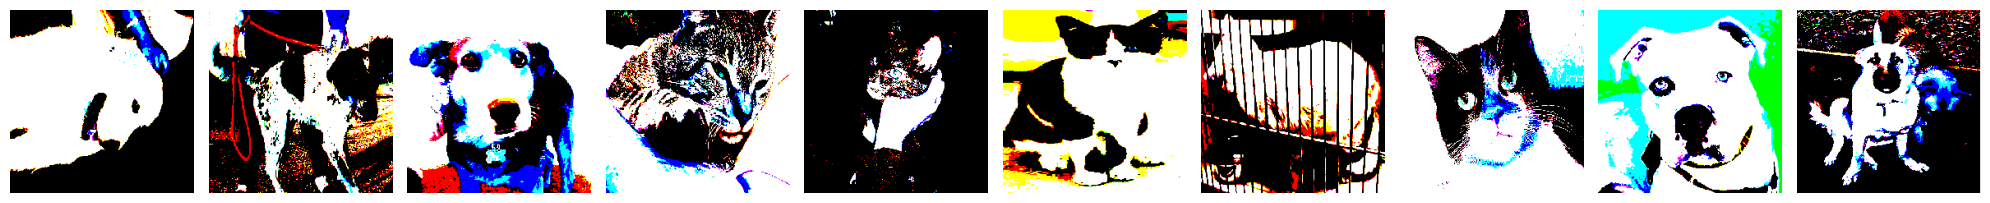

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [9]:
plotImages(imgs)
print(labels)

## Build and train CNN

### Question: When do you use categorical_cross_entropy as opposed to sparse_categorical_cross_entropy?
- Categorical_cross_entropy is typically used when there are more than two outputs from the model. Although it could also be used for outputs with two outputs such as this model below. Binary_cross_entropy with sigmoid activation is the alternative when there are only two classes. Sparse_categoroical_cross_entropy is used classes are mutually exclusives. Each sample belongs to only one single class. An example for this is the model at sequential.ipynb, where the data are integers. Categorical_cross_entropy is used in the model below because the data are images (2D array / matrix) which cannot be repesented by an integer but a hot encoded array.

In [10]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same"),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation="softmax"),
])

2023-10-16 18:24:44.170219: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 18:24:44.170359: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 18:24:44.170373: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 18:24:45.906865: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 18:24:45.906932: I tensorflow/compile

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10


2023-10-16 18:24:52.332254: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-16 18:24:58.085987: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-16 18:24:58.653694: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f427c00e830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-16 18:24:58.653744: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-10-16 18:24:58.761935: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-16 18:24:59.095018: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-16 18:24:59.196886: I ./tensorflow/compiler/jit/

100/100 - 30s - loss: 17.9654 - accuracy: 0.5610 - val_loss: 9.6901 - val_accuracy: 0.6000 - 30s/epoch - 296ms/step
Epoch 2/10
100/100 - 9s - loss: 5.0601 - accuracy: 0.7320 - val_loss: 8.1469 - val_accuracy: 0.5900 - 9s/epoch - 90ms/step
Epoch 3/10
100/100 - 9s - loss: 1.2567 - accuracy: 0.8700 - val_loss: 5.4219 - val_accuracy: 0.5900 - 9s/epoch - 89ms/step
Epoch 4/10
100/100 - 9s - loss: 0.4417 - accuracy: 0.9350 - val_loss: 7.4093 - val_accuracy: 0.5750 - 9s/epoch - 90ms/step
Epoch 5/10
100/100 - 10s - loss: 0.1985 - accuracy: 0.9600 - val_loss: 3.8449 - val_accuracy: 0.6450 - 10s/epoch - 96ms/step
Epoch 6/10
100/100 - 11s - loss: 0.1609 - accuracy: 0.9690 - val_loss: 4.9107 - val_accuracy: 0.6250 - 11s/epoch - 106ms/step
Epoch 7/10
100/100 - 10s - loss: 0.1509 - accuracy: 0.9650 - val_loss: 3.3023 - val_accuracy: 0.6650 - 10s/epoch - 101ms/step
Epoch 8/10
100/100 - 9s - loss: 0.0237 - accuracy: 0.9910 - val_loss: 3.6685 - val_accuracy: 0.6400 - 9s/epoch - 91ms/step
Epoch 9/10
